<img src='harry-potter-image.png' width='200px' style="float:left;margin-right:10pt"></img>
## Illustration of NWHypergraph <-> HyperNetX exchange using PyBind and Kaggle's HarryPotter dataset.

In this tutorial we introduce `hypernetx.StaticEntity` and `hypernetx.StaticEntitySet` and the new `static=True` attribute in the `hypernetx.Hypergraph` class. We also use PyBind to communicate with a C++ function in PNNL's **NWHypergraph (NWHy)** library to illustrate our current work to optimize HyperNetX for large datasets.

Harry Potter Data is available here: https://www.kaggle.com/gulsahdemiryurek/harry-potter-dataset.

Python code for parsing the dataset is in `harrypotter.py` in this tutorial's directory.

In [1]:
import hypernetx as hnx
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import scipy
from scipy.sparse import coo_matrix, csr_matrix, issparse
import pandas as pd
import numpy as np
import itertools as it
import nwhy    ##### library loaded in this Docker container, not yet available for distribution
import sys
sys.path.append('/home/ubuntu/hypernetx/tutorials/')
from harrypotter import HarryPotter

In [2]:
hogwarts = HarryPotter()

### The Harry Potter Dataset:
We have edited the dataset so that it has 5 categories and every cell is filled. Where a value is unknown, we marked it as "Unknown *category_name*". 

In [3]:
hogwarts.dataframe

,House,Blood status,Species,Hair colour,Eye colour
Id,,,,,
1,Gryffindor,Half-blood,Human,Black,Bright green
2,Gryffindor,Pure-blood,Human,Red,Blue
3,Gryffindor,Muggle-born,Human,Brown,Brown
4,Gryffindor,Half-blood,Human,Silver| formerly auburn,Blue
5,Gryffindor,Part-Human,Half-Human/Half-Giant,Black,Black
...,...,...,...,...,...
136,Unknown House,Unknown Blood status,Human,Grey,Unknown Eye colour
137,Unknown House,Unknown Blood status,Werewolf,Grey,Unknown Eye colour
138,Unknown House,Pure-blood or half-blood,Human,Blond,Blue


**We define a labeling based on the categories and store it in an OrderedDict.**   
The ordering of labels is determined by their order of appearance in the table with the exception of Unknown labels, which are always listed first.

In [4]:
hogwarts.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25')),
             ('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
 

**We next create a tensor with dimension equal to the number of categories and indexed by the labels.**  
The tensor is a 0-1 boolean tensor. A 1 in entry $(x_0,x_1,x_2,x_3,x_4, x_5)$ indicates that there is a record in the data corresponding to:

$
\text{'House':hogwarts.labels['House']}[x_0],\text{'Blood Status':hogwarts.labels['Blood Status']}[x_1]\text{...etc...}
$

The tensor may be stored as a list of its nonzero indices, or in a sparse format taking the transpose of that list, or as a `numpy.ndarray`.

In [5]:
## List of nonzero indices
hogwarts.data

array([[ 1,  1,  1,  1,  1],
       [ 1,  2,  1,  2,  2],
       [ 1,  3,  1,  3,  3],
       [ 1,  1,  1,  4,  2],
       [ 1,  4,  2,  1,  4],
       [ 1,  2,  1,  5,  0],
       [ 1,  2,  1,  2,  3],
       [ 1,  2,  1,  2,  3],
       [ 1,  2,  1,  2,  5],
       [ 1,  3,  1,  1,  3],
       [ 1,  1,  1,  6,  0],
       [ 1,  3,  1,  7,  1],
       [ 1,  2,  1,  1,  6],
       [ 1,  2,  1,  1,  7],
       [ 1,  1,  3,  8,  8],
       [ 1,  5,  1,  9,  2],
       [ 1,  2,  1,  2,  2],
       [ 1,  2,  4,  2,  2],
       [ 1,  2,  1,  2,  7],
       [ 1,  5,  1,  1,  3],
       [ 1,  5,  1,  0,  0],
       [ 1,  0,  1,  3,  3],
       [ 1,  5,  1,  3,  3],
       [ 1,  5,  1,  3,  3],
       [ 1,  2,  1,  5,  2],
       [ 1,  5,  1, 10,  9],
       [ 1,  5,  1,  1,  9],
       [ 1,  3,  1, 11,  0],
       [ 1,  5,  1,  5,  0],
       [ 1,  1,  1,  1,  8],
       [ 1,  2,  1,  2,  5],
       [ 1,  2,  1,  2,  8],
       [ 2,  1,  1,  0,  0],
       [ 2,  5,  1,  1,  9],
       [ 2,  5

In [6]:
## sparse tensor format
hogwarts.data.transpose()

array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         2,  2,  2,  3,  1,  2,  1,  0,  0,  0,  0,  3,  3,  4,  4,  2,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,
         0,  4,  0,  0,  5,  5,  6,  0,  0,  0,  0,  1,  3,  3,  4,  1,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  2,  3,  1,  4,  2,  2,  2,  2,  3,  1,  3,  2,  2,  1,  5,
         2,  2,  2,  5,  5,  0,  5,  5,  2,  5,  5,  3,  5,  1,  2,  2,
         1,  5,  5,  1,  6,  1,  1,  3,  5,  1,  5,  5,  1,  1,  2,  2,
         2,  2,  1,  5,  2,  2,  2,  5,  5,  1,  2,  2,  1,  5,  5,  5,
         7,  0,  5,  2,  5,  5,  0,  0,  5,  5,  0,  5,  5,  5,  0,  5,
       

In [7]:
## numpy.ndarray - note this will not be the way we store the data for our eventual release. 
## Rather, we will use a sparse format as in the last cell.
hogwarts.arr

array([[[[[1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[2, 0, 0, ..., 0, 0, 0],
          [1, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         ...,

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]],

         [[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
       

In [8]:
hogwarts.arr.shape

(7, 11, 10, 36, 26)

### StaticEntity and StaticEntitySet

The entire dataset has now been represented using an array and a dictionary associating positions in the array with values in the data.

The basic object in HyperNetX, which holds an array and label dictionary, is a `StaticEntity`.

Each dimension of the array, is considered a "level" in the StaticEntity. A level's order corresponds to its position in the datatable. In terms of the original Entity structure in HyperNetX, levels reference an order of containment. Elements of the the 2nd level belong to elements in the 1st column and so on.  The order of levels is given by the order of keys in the labels:

In [9]:
E = hnx.StaticEntity(arr = hogwarts.arr, labels = hogwarts.labels)
E.keys

array(['House', 'Blood status', 'Species', 'Hair colour', 'Eye colour'],
      dtype='<U12')

**Using the same nomenclature as `hypernetx.Entity`, the elements of a StaticEntity refer to the first level and its children refer to the second level.**

In [10]:
E = hnx.StaticEntity(arr=hogwarts.arr, labels=hogwarts.labels)
E.elements,E.children

(OrderedDict([('Unknown House',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Part-Human']),
              ('Gryffindor',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Muggle-born',
                'Part-Human']),
              ('Ravenclaw',
               ['Unknown Blood status',
                'Half-blood',
                'Muggle-born',
                'Part-Human']),
              ('Slytherin', ['Half-blood', 'Pure-blood', 'Part-Human']),
              ('Hufflepuff', ['Half-blood', 'Pure-blood or half-blood']),
              ('Beauxbatons Academy of Magic',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Muggle-born',
                'Part-Human',
                'Part-Goblin']),
              ('Durmstrang Institute', ['Pure-blood'])]),
 {'Half-blood',
  'Muggle',
  'Muggle

**Levels can be reordered and any pair of columns may be organized to be elements and children.**

In [11]:
E.elements_by_level(level1=2,level2=3,translate=True)

OrderedDict([('Unknown Species',
              ['Unknown Hair colour',
               'Black',
               'Red',
               'Silver| formerly auburn']),
             ('Human',
              ['Unknown Hair colour',
               'Black',
               'Red',
               'Brown',
               'Silver| formerly auburn']),
             ('Half-Human/Half-Giant',
              ['Unknown Hair colour',
               'Black',
               'Brown',
               'Silver| formerly auburn']),
             ('Werewolf', ['Black', 'Red', 'Silver| formerly auburn']),
             ('Human (Werewolf traits)', ['Black', 'Blond']),
             ('Human(goblin ancestry)',
              ['Unknown Hair colour',
               'Black',
               'Red',
               'Brown',
               'Silver| formerly auburn',
               'Sandy']),
             ('Ghost', ['Red']),
             ('Centaur', ['Red']),
             ('Human (Metamorphmagus)', ['Blond']),
             ('Elf', ['Un

In [12]:
F = E.restrict_to_levels([2,3,1]) ## This generates a new StaticEntity
F.labels

OrderedDict([('Species',
              array(['Unknown Species', 'Human', 'Half-Human/Half-Giant', 'Werewolf',
                     'Human (Werewolf traits)', 'Human(goblin ancestry)', 'Ghost',
                     'Centaur', 'Human (Metamorphmagus)', 'Elf'], dtype='<U23')),
             ('Hair colour',
              array(['Unknown Hair colour', 'Black', 'Red', 'Brown',
                     'Silver| formerly auburn', 'Blond', 'Sandy', 'Auburn',
                     'Light brown flecked with grey', 'Colourless and balding', 'Dark',
                     'Mousy', 'Dirty-blonde', 'White', 'Reddish-blonde', 'Blonde',
                     'White-blond', 'Iron grey', 'Bald', 'Grey', 'White (balding)',
                     'Straw blond', 'Variable', 'Red brown', 'Brown/greying',
                     'Silver| formerly black', 'Tawny', 'Silver', 'Silvery-blonde',
                     'Ginger', 'Straw-coloured', 'Red ', 'Reddish-brown', 'Mousy brown',
                     'Jet-black', 'White blo

In [13]:
F.elements

OrderedDict([('Unknown Species',
              ['Unknown Hair colour',
               'Black',
               'Sandy',
               'Colourless and balding']),
             ('Human', ['Black', 'Red', 'Sandy']),
             ('Half-Human/Half-Giant', ['Black', 'Silver| formerly auburn']),
             ('Werewolf', ['Black', 'Red', 'Sandy']),
             ('Human (Werewolf traits)', ['Black']),
             ('Human(goblin ancestry)', ['Black']),
             ('Ghost', ['Black']),
             ('Centaur', ['Black']),
             ('Human (Metamorphmagus)', ['Brown']),
             ('Elf', ['Black'])])

### A StaticEntitySet is a StaticEntity restricted to two levels. 
By default, a StaticEntity will grab the 1st two dimensions of the of the array and first two keys of the labels, but any pair of levels may be specified. 

In [14]:
ES = hnx.StaticEntitySet(arr=hogwarts.arr, labels=hogwarts.labels, level1=0, level2=1)

In [15]:
ES.labels

OrderedDict([('House',
              array(['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin',
                     'Hufflepuff', 'Beauxbatons Academy of Magic',
                     'Durmstrang Institute'], dtype='<U28')),
             ('Blood status',
              array(['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born',
                     'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin',
                     'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],
                    dtype='<U25'))])

## Static Hypergraph
A static hypergraph is one where all nodes and edges are known at the time of construction. This permits an internal ordering and uid structure for easy reference and faster computation of metrics.

The nodes and edges of a static Hypergraph are stored using the StaticEntitySet structure. 

A static Hypergraph may be instantiated by adding the keyword argument `static=True`. Hypergraphs have `static=False` by default. A static Hypergraph may be created with a set system of the form:
1. *dict* with static=True 
2. *iterable of iterables* with static=True, 
3. `hypernetx.EntitySet` with static=True
4. `hypernetx.StaticEntity` (static is automatically set to True),
5. `hypernetx.StaticEntitySet` (static is automatically set to True).


In [16]:
## example, instantiate from a dictionary
d = E.elements
Hdict = hnx.Hypergraph(d,static=True)

d,Hdict.edges.keys,Hdict.isstatic,Hdict.nodes,Hdict.edges

(OrderedDict([('Unknown House',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Part-Human']),
              ('Gryffindor',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Muggle-born',
                'Part-Human']),
              ('Ravenclaw',
               ['Unknown Blood status',
                'Half-blood',
                'Muggle-born',
                'Part-Human']),
              ('Slytherin', ['Half-blood', 'Pure-blood', 'Part-Human']),
              ('Hufflepuff', ['Half-blood', 'Pure-blood or half-blood']),
              ('Beauxbatons Academy of Magic',
               ['Unknown Blood status',
                'Half-blood',
                'Pure-blood',
                'Muggle-born',
                'Part-Human',
                'Part-Goblin']),
              ('Durmstrang Institute', ['Pure-blood'])]),
 array(['level1', 'level2'], dtype='<

In [17]:
## example, instantiate from an Entity
H = hnx.Hypergraph(E)

H.edges.keys,H.isstatic,H.nodes,H.edges

(array(['House', 'Blood status'], dtype='<U12'),
 True,
 StaticEntitySet(None,['Unknown Blood status', 'Half-blood', 'Pure-blood', 'Muggle-born', 'Part-Human', 'Pure-blood or half-blood', 'Part-Goblin', 'Muggle-born or half-blood', 'Quarter-Veela', 'Muggle', 'Squib'],{}),
 StaticEntitySet(None,['Unknown House', 'Gryffindor', 'Ravenclaw', 'Slytherin', 'Hufflepuff', 'Beauxbatons Academy of Magic', 'Durmstrang Institute'],{}))

**Restrict to specific edges and nodes as before**

In [18]:
H = H.restrict_to_edges(['Gryffindor','Ravenclaw','Slytherin','Hufflepuff'])
H.edges

StaticEntitySet(None,['Gryffindor', 'Ravenclaw', 'Slytherin', 'Hufflepuff'],{})

**A Hypergraph with static=True may be converted to a static=False hypergraph if dynamic properties or visualizations are needed.**  
(Similarly any hypergraph may be converted to a static hypergraph using its incidence_dict.)

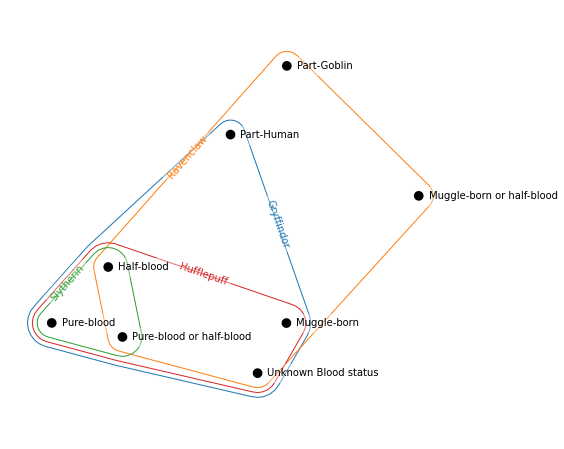

In [19]:
Hd = H.remove_static()
hnx.draw(Hd)

## NWHypergraph (NWHy) has fast methods to apply to Hypergraphs stored as sparse arrays

### All s-metric calculations in HNX use an s-line graph representation of the Hypergraph
For each integer s>0, a hypergraph generates a unique s-line graph. The vertices in the line graph correspond to hypergraph edges. There exists a line graph edge between two line graph vertices if the hypergraph edges they represent intersect in at least s nodes in the hypergraph.

Because this line graph representation is so important for all s-metrics, our proof of concept demonstration has NWHy calculating the s-line graphs of hypergraphs passed from their python representation.

**The nwhy.convert_to_s_overlap returns the adjacency matrix and index corresponding to the s-line graph.**

In [20]:
H.incidence_matrix()  ## the edge data for H is stored in the array associated with its edges, a StaticEntitySet

<8x4 sparse matrix of type '<class 'numpy.int64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [21]:
H.edges.elements

OrderedDict([('Gryffindor',
              ['Unknown Blood status',
               'Half-blood',
               'Pure-blood',
               'Muggle-born',
               'Part-Human',
               'Pure-blood or half-blood']),
             ('Ravenclaw',
              ['Unknown Blood status',
               'Half-blood',
               'Muggle-born',
               'Pure-blood or half-blood',
               'Part-Goblin',
               'Muggle-born or half-blood']),
             ('Slytherin',
              ['Half-blood', 'Pure-blood', 'Pure-blood or half-blood']),
             ('Hufflepuff',
              ['Unknown Blood status',
               'Half-blood',
               'Pure-blood',
               'Muggle-born',
               'Pure-blood or half-blood'])])

**HNX exchanges matrices with NWHypergraph using the sparse format of three arrays: row_indices, column_indices, data**

In [22]:
hpcoo = coo_matrix(H.incidence_matrix().transpose())
hpcoo.row,hpcoo.col,hpcoo.data

(array([0, 1, 3, 0, 1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 0, 1, 2, 3, 1, 1],
       dtype=int32),
 array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 7],
       dtype=int32),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [23]:
mat = H.incidence_matrix(index=True)
mat[0].transpose().todense(),mat[1],mat[2]

(matrix([[1, 1, 1, 1, 1, 1, 0, 0],
         [1, 1, 0, 1, 0, 1, 1, 1],
         [0, 1, 1, 0, 0, 1, 0, 0],
         [1, 1, 1, 1, 0, 1, 0, 0]]),
 {0: 'Unknown Blood status',
  1: 'Half-blood',
  2: 'Pure-blood',
  3: 'Muggle-born',
  4: 'Part-Human',
  5: 'Pure-blood or half-blood',
  6: 'Part-Goblin',
  7: 'Muggle-born or half-blood'},
 {0: 'Gryffindor', 1: 'Ravenclaw', 2: 'Slytherin', 3: 'Hufflepuff'})

In [24]:
H.edge_adjacency_matrix(s=2).todense()

matrix([[0, 4, 3, 5],
        [4, 0, 2, 4],
        [3, 2, 0, 3],
        [5, 4, 3, 0]])

**We retrieve the s line graph for multiple values of s and return the s-metrics**

The newrow,newcol,newdata are indices generated by NWHy to reference the edges in H.   
These provide coordinate for the upper triangular portion of the s-adjacency matrix.  

The oldrow,oldcol,olddata return a mapping of these indices to the same ones used by HNX.

In [25]:
## Call nwhy to retrieve the s-adjacent pairs of edges:
newrow, newcol, newdata, oldrow, oldcol, olddata = nwhy.convert_to_s_overlap(hpcoo.row, hpcoo.col, hpcoo.data, s = 2)

## Turn this information into an s-adjacency matrix
xcoords = np.concatenate([oldrow,oldcol])
ycoords = np.concatenate([oldcol,oldrow])
nwhy_matrix = csr_matrix((np.ones(len(xcoords),dtype=int),(xcoords,ycoords))).todense()

## Verify this matches the HNX generated s-edge adjacency matrix
hnx_matrix = H.edge_adjacency_matrix(s=2,weighted=False).todense()

print(nwhy_matrix);print(hnx_matrix)

[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
[[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]


In [26]:
## repeat for multiple values of s:
def comparison(s):
    newrow, newcol, newdata, oldrow, oldcol, olddata = nwhy.convert_to_s_overlap(hpcoo.row, hpcoo.col, hpcoo.data, s = s)

    ## Turn this information into an s-adjacency matrix
    xcoords = np.concatenate([oldrow,oldcol])
    ycoords = np.concatenate([oldcol,oldrow])
    nwhy_matrix = csr_matrix((np.ones(len(xcoords),dtype=int),(xcoords,ycoords))).todense()

    ## Verify this matches the HNX generated s-edge adjacency matrix
    hnx_matrix = H.edge_adjacency_matrix(s=s,weighted=False).todense()

    print(nwhy_matrix);print(hnx_matrix)

for s in range(3,6):
    comparison(s)
    print()

[[0 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 1 1 0]]
[[0 1 1 1]
 [1 0 0 1]
 [1 0 0 1]
 [1 1 1 0]]

[[0 1 0 1]
 [1 0 0 1]
 [0 0 0 0]
 [1 1 0 0]]
[[0 1 0 1]
 [1 0 0 1]
 [0 0 0 0]
 [1 1 0 0]]

[[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]]
[[0 0 0 1]
 [0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]]



## Looking ahead:

Once NWHy has stored the s-graph adjacency matrix, all of the s-metrics we currently compute using Python libraries, may now be computed using the NWGraph and NWHypergraph libraries. This will permit us to continue using the HNX Python interface but optimized for large datasets.